<a href="https://colab.research.google.com/github/Erre-vicu/PEA-DS-DMC/blob/main/Trabajo_Final_Robinson_R%C3%ADos_Vicu%C3%B1a_M%C3%A9todos_no_Supervisados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentacion RFM y PAM

Caso: Consiste en conocera tus clientes a traves de los consumos que realiza en los centros comerciales con su tarjeta de crédito, analice bajo la metodologia RFM(Experto - analítico) y proponga cuáles serían los segmentos comerciales.

## 1. Librerías

In [ ]:
!pip install squarify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import seaborn as sns
import squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Extracción de Base de Datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Métodos no Supervisados/Datos/03 dataBaseConsumo.txt", sep="|", encoding="latin-1")
df.drop(columns={"grupoGiro"}, inplace=True)
df.head(5)

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2


In [ ]:
df.shape

(339476, 9)

Creamos la Base de Datos con todos los periodos históricos de consumo e incluimos una variable de índice para los posteriores tratamientos.

In [ ]:
#Creamos un campo de fecha para que nos ayude a tratar la agregación y disminución de meses

df2=df.copy()

In [ ]:
#Copiamos la columna codmes y la transformamos a fecha en otra columna llamada de la misma forma
df2["fecha"]=df2["codmes"]
df2["fecha"]=df2["fecha"].apply(lambda x: str(x)+"01")
df2["fecha"]=pd.to_datetime(df2["fecha"])
df2.head()

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx,fecha
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1,2016-11-01
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1,2016-11-01
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1,2016-11-01
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4,2016-12-01
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2,2016-11-01


In [ ]:
#Creamos la agrupación por fecha y cliente y sumamos el índice que nos servirá para futuro
dbGroup=df2.groupby(["fecha", "cliente"]).agg({"trx":sum, "monto":sum})
dbGroup["ind"]=1
dbGroup=dbGroup.reset_index()
dbGroup.head()

,fecha,cliente,trx,monto,ind
0,2016-11-01,1,5,266,1
1,2016-11-01,2,8,453,1
2,2016-11-01,3,7,1676,1
3,2016-11-01,4,15,1186,1
4,2016-11-01,6,1,4,1


## 3. Universo

In [ ]:
print(dbGroup["fecha"].max()) #ubicamos la fecha maxima para utilizar un estudio de meses anteriores a ello.

#Filtramos por universo
dbUniv=dbGroup.copy()
dbUniv=dbUniv[dbUniv["fecha"]=="2017-10-01"]
dbUniv.rename(columns={"fecha":"periodo"}, inplace=True)
dbUniv=dbUniv[["periodo", "cliente"]]
dbUniv.head()

2017-10-01 00:00:00


,periodo,cliente
150227,2017-10-01,1
150228,2017-10-01,2
150229,2017-10-01,3
150230,2017-10-01,4
150231,2017-10-01,5


In [ ]:
#Creamos las 3 columnas con fechas para análisis históricas.

from dateutil.relativedelta import relativedelta
mes=relativedelta(months=1)

for x in range(3):
  dbUniv["fec_" + str(x+1)]=\
  pd.to_datetime(dbUniv["periodo"].apply(lambda x: x-mes)) 

dbUniv["fec_2"]=pd.to_datetime(dbUniv["fec_1"].apply(lambda x: x-mes))
dbUniv["fec_3"]=pd.to_datetime(dbUniv["fec_2"].apply(lambda x: x-mes))
dbUniv.head()

,periodo,cliente,fec_1,fec_2,fec_3
150227,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01
150228,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01
150229,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01
150230,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01
150231,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01


## 4. Desarrollo base para RFM+t

Creamos la base final con la que haremos el merge de las columnas para futuros análisis.

In [ ]:
df_final = pd.merge(dbUniv, dbGroup[["fecha", "cliente", "monto", "trx", "ind"]], how="left",
                    left_on=["fec_1", "cliente"], right_on=["fecha", "cliente"])
df_final = pd.merge(df_final, dbGroup[["fecha", "cliente", "monto", "trx", "ind"]], how="left",
                    left_on=["fec_2", "cliente"], right_on=["fecha", "cliente"])
df_final = pd.merge(df_final, dbGroup[["fecha", "cliente", "monto", "trx", "ind"]], how="left",
                    left_on=["fec_3", "cliente"], right_on=["fecha", "cliente"])

In [ ]:
df_final.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,monto_y,trx_y,ind_y,fecha,monto,trx,ind
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,210.0,2.0,1.0,2017-07-01,346.0,5.0,1.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,586.0,2.0,1.0,2017-07-01,255.0,2.0,1.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,1701.0,11.0,1.0,2017-07-01,601.0,8.0,1.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,7.0,1.0,1.0,NaT,NaN,NaN,NaN


In [ ]:
#Agregamos las columnas con los datos diferenciados.

df_final["M1"]=df_final["ind_x"].apply(lambda x: 1 if x==1 else 0)
df_final["Monto_1"]=df_final["monto_x"].fillna(0)
df_final["Trx_1"]=df_final["trx_x"].fillna(0)

df_final["M2"]=df_final["ind_y"].apply(lambda x: 1 if x==1 else 0)
df_final["Monto_2"]=df_final["monto_y"].fillna(0)
df_final["Trx_2"]=df_final["trx_y"].fillna(0)

df_final["M3"]=df_final["ind"].apply(lambda x: 1 if x==1 else 0)
df_final["Monto_3"]=df_final["monto"].fillna(0)
df_final["Trx_3"]=df_final["trx"].fillna(0)

In [ ]:
#Filtramos la data final con las columnas a utilizar.

df_final=df_final[["periodo","cliente","M1", "M2", "M3", "Monto_1", "Monto_2","Monto_3", "Trx_1", "Trx_2", "Trx_3"]]

In [ ]:
df_final.head()

,periodo,cliente,M1,M2,M3,Monto_1,Monto_2,Monto_3,Trx_1,Trx_2,Trx_3
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,0.0,2.0,5.0
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,0.0,0.0
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,9.0,2.0,2.0
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,16.0,11.0,8.0
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,0.0,1.0,0.0


### 4.1 Formando R+F+M+t

In [ ]:
df_final["frec"] = df_final["M1"]+df_final["M2"]+df_final["M3"]
df_final["rec"] = np.where(df_final["M1"]==1,3, np.where(df_final["M2"]==1,2, np.where(df_final["M3"]==1,1,0)))
df_final["monto3um"] = np.where(df_final["frec"]>0,
                                (df_final["Monto_1"]+df_final["Monto_2"]+df_final["Monto_3"])/df_final["frec"],0)
df_final["PromTrx"] = np.where(df_final["frec"]>0,
                                (df_final["Trx_1"]+df_final["Trx_2"]+df_final["Trx_3"])/df_final["frec"],0)

<ipython-input-14-eb4ea55070b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["frec"] = df_final["M1"]+df_final["M2"]+df_final["M3"]
<ipython-input-14-eb4ea55070b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["rec"] = np.where(df_final["M1"]==1,3, np.where(df_final["M2"]==1,2, np.where(df_final["M3"]==1,1,0)))
<ipython-input-14-eb4ea55070b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
df_final.head(10)

,periodo,cliente,M1,M2,M3,Monto_1,Monto_2,Monto_3,Trx_1,Trx_2,Trx_3,frec,rec,monto3um,PromTrx
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,0.0,2.0,5.0,2,2,278.000000,3.500000
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,0.0,0.0,1,3,228.000000,1.000000
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,9.0,2.0,2.0,3,3,844.000000,4.333333
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,16.0,11.0,8.0,3,3,1650.666667,11.666667
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,0.0,1.0,0.0,1,2,7.000000,1.000000
5,2017-10-01,6,0,1,0,0.0,350.0,0.0,0.0,1.0,0.0,1,2,350.000000,1.000000
6,2017-10-01,9,1,1,1,325.0,81.0,51.0,5.0,1.0,1.0,3,3,152.333333,2.333333
7,2017-10-01,11,1,0,0,187.0,0.0,0.0,2.0,0.0,0.0,1,3,187.000000,2.000000
8,2017-10-01,12,1,1,1,27.0,27.0,27.0,1.0,1.0,1.0,3,3,27.000000,1.000000
9,2017-10-01,13,0,1,1,0.0,45.0,75.0,0.0,1.0,1.0,2,2,60.000000,1.000000


### 4.2 Corte

Para el corte podremos utilizar distintas técnicas como kmeans, deciles, mediana o promedio, depende del negocio, en este caso siguiente lo trabajado en clase utilizaremos la mediana.

In [ ]:
corteMonto=df_final["monto3um"][df_final["monto3um"]>0].median()
print("La mediana para el corteMonto es: ", corteMonto)

La mediana para el corteMonto es:  165.33333333333334


In [ ]:
corteTrx=df_final["PromTrx"][df_final["PromTrx"]>0].median()
print("La mediana para el corteTrx es: ", corteTrx)

La mediana para el corteTrx es:  2.5


### 4.3 Etiqueta de Monto

In [ ]:
#Etiquetamos la data

df_final["Monto"]=df_final["monto3um"].apply(lambda x: "Alto" if x >= corteMonto else "Bajo")
df_final["Trx"]=df_final["PromTrx"].apply(lambda x: "Alto" if x >= corteTrx else "Bajo")
df_final = df_final[["periodo", "cliente", "monto3um", "rec", "frec","PromTrx", "Monto", "Trx"]]
df_final = df_final[~((df_final["frec"]>0)&(df_final["monto3um"]==0))]
df_final.head(10)

<ipython-input-18-edf66faa84b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Monto"]=df_final["monto3um"].apply(lambda x: "Alto" if x >= corteMonto else "Bajo")
<ipython-input-18-edf66faa84b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Trx"]=df_final["PromTrx"].apply(lambda x: "Alto" if x >= corteTrx else "Bajo")


,periodo,cliente,monto3um,rec,frec,PromTrx,Monto,Trx
0,2017-10-01,1,278.000000,2,2,3.500000,Alto,Alto
1,2017-10-01,2,228.000000,3,1,1.000000,Alto,Bajo
2,2017-10-01,3,844.000000,3,3,4.333333,Alto,Alto
3,2017-10-01,4,1650.666667,3,3,11.666667,Alto,Alto
4,2017-10-01,5,7.000000,2,1,1.000000,Bajo,Bajo
5,2017-10-01,6,350.000000,2,1,1.000000,Alto,Bajo
6,2017-10-01,9,152.333333,3,3,2.333333,Bajo,Bajo
7,2017-10-01,11,187.000000,3,1,2.000000,Alto,Bajo
8,2017-10-01,12,27.000000,3,3,1.000000,Bajo,Bajo
9,2017-10-01,13,60.000000,2,2,1.000000,Bajo,Bajo


In [ ]:
nTotal=df_final[df_final["rec"]>0].count()[0]
resumRfm = df_final[df_final["rec"]>0].groupby(["rec", "frec", "Monto", "Trx"]).agg({"cliente":"count"})\
                                      .sort_values(by=["rec", "frec"], ascending=False)

In [ ]:
resumRfm = resumRfm.reset_index()
resumRfm["%"]=round(100*resumRfm["cliente"]/nTotal,1)
print(f"Clientes Total: {nTotal}\n")
print(resumRfm)

Clientes Total: 10806

    rec  frec Monto   Trx  cliente     %
0     3     3  Alto  Alto     2540  23.5
1     3     3  Alto  Bajo      543   5.0
2     3     3  Bajo  Alto      802   7.4
3     3     3  Bajo  Bajo     1098  10.2
4     3     2  Alto  Alto      571   5.3
5     3     2  Alto  Bajo      300   2.8
6     3     2  Bajo  Alto      334   3.1
7     3     2  Bajo  Bajo      827   7.7
8     3     1  Alto  Alto      265   2.5
9     3     1  Alto  Bajo      214   2.0
10    3     1  Bajo  Alto      164   1.5
11    3     1  Bajo  Bajo      737   6.8
12    2     2  Alto  Alto      318   2.9
13    2     2  Alto  Bajo      156   1.4
14    2     2  Bajo  Alto      160   1.5
15    2     2  Bajo  Bajo      363   3.4
16    2     1  Alto  Alto       94   0.9
17    2     1  Alto  Bajo      148   1.4
18    2     1  Bajo  Alto       43   0.4
19    2     1  Bajo  Bajo      390   3.6
20    1     1  Alto  Alto      108   1.0
21    1     1  Alto  Bajo      149   1.4
22    1     1  Bajo  Alto       81

## 5. Etiqueta de Segmentos

In [ ]:
# dbRFMt=pd.DataFrame()
dbRFMt=df_final[df_final["rec"]>0].copy()

In [ ]:
#Etiquetamos los segmentos.

dbRFMt['rfm'] = np.where((dbRFMt['rec']==3)&(dbRFMt['frec']==3)&(dbRFMt['Monto']=='Alto')&(dbRFMt["Trx"].isin(["Alto", "Bajo"])),'1. fidelizado',
                np.where((dbRFMt['rec']==3)&(dbRFMt['frec'].isin([2,1]))&(dbRFMt['Monto']=='Alto')&(dbRFMt["Trx"].isin(["Alto","Bajo"])),'2. potencial_fidelizado',
                np.where((dbRFMt['rec'].isin([2,1]))&(dbRFMt['frec'].isin([2,1]))&(dbRFMt['Monto']=='Alto')&(dbRFMt["Trx"].isin(["Alto","Bajo"])),'3. maduración',
                np.where((dbRFMt['rec']==3)&(dbRFMt['frec']==3)&(dbRFMt['Monto']=='Bajo')&(dbRFMt["Trx"].isin(["Alto", "Bajo"])),'4. reengachados',
                np.where((dbRFMt['rec'].isin([3,2]))&(dbRFMt['Monto']=='Bajo')&(dbRFMt["Trx"].isin(["Alto","Bajo"])),'5. desganado',
                np.where((dbRFMt['rec']==1)&(dbRFMt['frec']==1)&(dbRFMt['Monto']=='Bajo')&(dbRFMt["Trx"].isin(["Alto","Bajo"])),'6. potencial_inactivo','7. None'))))))

In [ ]:
dbRFMt.head()

,periodo,cliente,monto3um,rec,frec,PromTrx,Monto,Trx,rfm
0,2017-10-01,1,278.000000,2,2,3.500000,Alto,Alto,3. maduración
1,2017-10-01,2,228.000000,3,1,1.000000,Alto,Bajo,2. potencial_fidelizado
2,2017-10-01,3,844.000000,3,3,4.333333,Alto,Alto,1. fidelizado
3,2017-10-01,4,1650.666667,3,3,11.666667,Alto,Alto,1. fidelizado
4,2017-10-01,5,7.000000,2,1,1.000000,Bajo,Bajo,5. desganado


### 5.1 Conclusion del Segmento

In [ ]:
resum = dbRFMt.groupby(["rfm"]).agg({"cliente":"count", "rec":"mean", "frec":"mean", "monto3um":"mean"})\
                              .sort_values(by="rfm")
resum.reset_index()
resum["%"] = round(100*resum["cliente"]/dbRFMt.count()[0],1)
print(f"Clientes totales: {dbRFMt.count()[0]}\n")
print(resum)

Clientes totales: 10806

                         cliente       rec      frec    monto3um     %
rfm                                                                   
1. fidelizado               3083  3.000000  3.000000  884.578657  28.5
2. potencial_fidelizado     1350  3.000000  1.645185  678.262593  12.5
3. maduración                973  1.735868  1.487153  711.881295   9.0
4. reengachados             1900  3.000000  3.000000   80.344035  17.6
5. desganado                3018  2.683234  1.557985   63.458416  27.9
6. potencial_inactivo        482  1.000000  1.000000   60.273859   4.5


# 6. Herramienta PAM

## 6.1 Librerias

In [ ]:
!pip install kmodes
from kmodes.kmodes import KModes
from sklearn import preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 6.2 Etiquetado

In [ ]:
# dbkmodes = pd.DataFrame()
dbkmodes = dbRFMt.copy()

In [ ]:
cod = preprocessing.LabelEncoder()
dbkmodes = dbkmodes[["rec", "frec", "Monto", "Trx"]].apply(cod.fit_transform)

## 6.3 Clustering

In [ ]:
cost=[]
cluster=[]

for i in list(range(1,9)):
  model = KModes(n_clusters=i, init="Cao", n_init=1, verbose=1)
  cluster.append(model.fit_predict(dbkmodes))
  cost.append(model.cost_)
print(model.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 18960.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10286.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 9039.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 8165.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 7373.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 7157.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 6355.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10

## 6.4 Evolución Cluster VS Costo

Este gráfico nos ayudará a analizar la evolución de los valores del costo cada vez que sugiere cierto número de cluster, lo ideal es tomar aquellos costos menores.

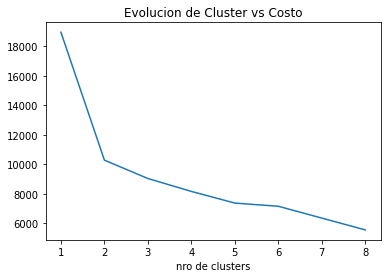

In [ ]:
rango = np.array(range(1,len(cost)+1))
plt.plot(rango, cost)
plt.title("Evolucion de Cluster vs Costo")
plt.xlabel("nro de clusters")
plt.show()

## 6.5 Análisis del Cluster

In [ ]:
numClus=[2,3,4,5,6] #Utilizamos los cluster del 2 al 6 que es donde se ve el ultimo corte luego es flat.

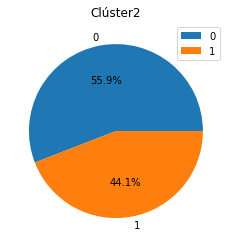

         ctdCliente  pctCliente
cluster                        
0              6040       55.89
1              4766       44.11




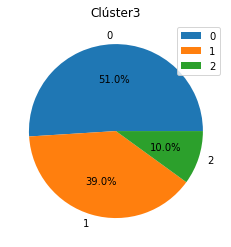

         ctdCliente  pctCliente
cluster                        
0              5510       50.99
1              4216       39.02
2              1080        9.99




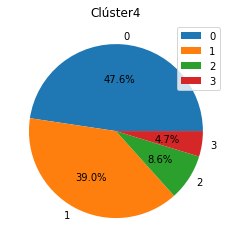

         ctdCliente  pctCliente
cluster                        
0              5147       47.63
1              4216       39.02
2               932        8.62
3               511        4.73




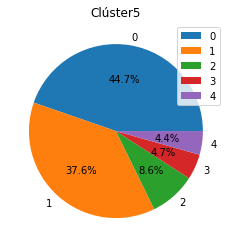

         ctdCliente  pctCliente
cluster                        
0              4829       44.69
1              4060       37.57
2               932        8.62
3               511        4.73
4               474        4.39




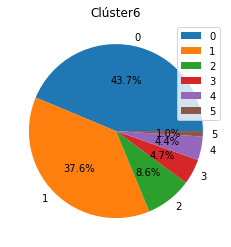

         ctdCliente  pctCliente
cluster                        
0              4721       43.69
1              4060       37.57
2               932        8.62
3               511        4.73
4               474        4.39
5               108        1.00




In [ ]:
copy=pd.DataFrame()
for i in numClus:
  copy["cluster"]=cluster[i-1]
  ctdGrupo = pd.DataFrame()
  ctdGrupo["ctdCliente"]=copy.groupby("cluster").size()
  ctdGrupo["pctCliente"]=np.round(100*ctdGrupo["ctdCliente"]/ctdGrupo["ctdCliente"].sum(),2)

  #Gráfico de los grupos según su distribución:
  plt.pie(ctdGrupo["pctCliente"], labels=ctdGrupo.index, autopct="%1.1f%%")
  plt.title("Clúster" + str(i))
  plt.legend()
  plt.show()
  print(ctdGrupo)
  print("\n")

# Base Final del Cluster

In [ ]:
n_cluster = int(input("Ingrese el Nro de Cluster: "))

Ingrese el Nro de Cluster: 4


In [ ]:
df = dbRFMt.copy()
df["Cluster"] = cluster[n_cluster-1]

In [ ]:
df.head()

,periodo,cliente,monto3um,rec,frec,PromTrx,Monto,Trx,rfm,Cluster
0,2017-10-01,1,278.000000,2,2,3.500000,Alto,Alto,3. maduración,0
1,2017-10-01,2,228.000000,3,1,1.000000,Alto,Bajo,2. potencial_fidelizado,3
2,2017-10-01,3,844.000000,3,3,4.333333,Alto,Alto,1. fidelizado,0
3,2017-10-01,4,1650.666667,3,3,11.666667,Alto,Alto,1. fidelizado,0
4,2017-10-01,5,7.000000,2,1,1.000000,Bajo,Bajo,5. desganado,2


# 7. RFM+t Método Analítico

In [ ]:
resClus = df.groupby(["Cluster"]).agg({"cliente":"count", "rec":"mean", "frec":"mean", "monto3um":"mean", "PromTrx":"mean"})\
                                  .sort_values(by="Cluster")
resClus = resClus.reset_index()
resClus["%"]=round(100*resClus["cliente"]/dbRFMt.count()[0],1)
print(f"Clientes totales: {dbRFMt.count()[0]}\n")
print(resClus)

Clientes totales: 10806

   Cluster  cliente       rec      frec    monto3um   PromTrx     %
0        0     5147  2.896250  2.682339  726.649990  5.319960  47.6
1        1     4216  2.686670  1.990512  120.702720  1.622035  39.0
2        2      932  2.089056  1.171674  152.067597  2.754292   8.6
3        3      511  2.127202  1.000000  622.342466  1.473581   4.7


## 7.1 Etiquetado del Segmento

In [ ]:
resClus["segmento"]=resClus["Cluster"].apply(lambda x: "fidelizado" if x == 0 else
                                             ("reenganchado" if x == 1 else
                                              ("desganado" if x == 2 else 
                                               ("maduración" if x == 3 else "None"))))

In [ ]:
resSeg=resClus.groupby(["segmento", "Cluster"]).agg({"cliente":"sum", "rec":"mean", "frec":"mean","monto3um":"mean", "PromTrx":"mean"})
resSeg.sort_values(by="Cluster", inplace=True)
resSeg["%"]=round(100*resSeg["cliente"]/dbRFMt.count()[0],1)
resSeg

,,cliente,rec,frec,monto3um,PromTrx,%
segmento,Cluster,,,,,,
fidelizado,0,5147,2.896250,2.682339,726.649990,5.319960,47.6
reenganchado,1,4216,2.686670,1.990512,120.702720,1.622035,39.0
desganado,2,932,2.089056,1.171674,152.067597,2.754292,8.6
maduración,3,511,2.127202,1.000000,622.342466,1.473581,4.7


## Conclusiones

* Dentro de nuestro análisis tenemos 4 segmentos, y podemos observar que podríamos reconsiderar nuestra lógica de segmentación, ya que como podemos observar, en  nuestro grupo de fidelizados no necesariamente se encuentran los clientes que tienen recencia y frecuencia 3, ya que el modelo nos muestra que los fidelizados pueden estar dentro de valores menores y estaríamos perdiendo clientes.

* Algo a recalcar es que el modelo no nos muestra que exista una segmentación de "posibles inactivos" como nosotros habríamos etiquetado, por el contrario podríamos considerarlos en otro grupo para ganar clientes dentro de otro grupo.

* El promedio de transacciones y el monto de suma del grupo "desganado" es mayor al del segmento reenganchado, en este caso debemos analizar como llevar al cliente desganado a que suba su recencia y frecuencia.

* El segmento 3 "maduración" es el segundo grupo con un monto alto y su recencia y frecuencia bajos, se debe buscar la forma de fidelizar a este segmento.

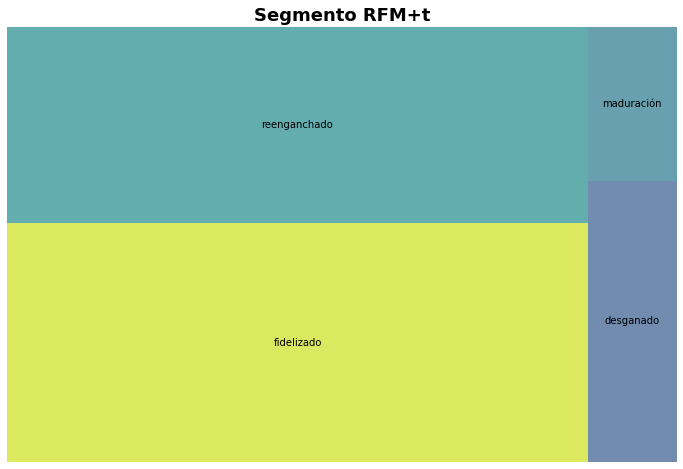

In [ ]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=resClus['%'],
              label=['fidelizado',
                     'reenganchado',
                     'desganado',
                     'maduración'], alpha=0.7 )
plt.title("Segmento RFM+t",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()